# NYC Jobs Data Engineering Assessment
Author: Saurabh Tikekar  
Role: Data Engineering Assessment  

## Purpose
This notebook evaluates:
- Data exploration skills
- Data engineering & transformation capability
- Feature engineering
- KPI derivation
- Testing mindset
- Production readiness thinking

Dataset: NYC Job Postings (nyc-jobs.csv)

In [ ]:
import findspark
findspark.init()

In [32]:
from pyspark.sql import SparkSession, DataFrame

# Connect to Spark cluster when running in Docker (master is set via env MASTER=spark://master:7077)
spark = SparkSession.builder \
    .appName("pyspark-assesment") \
    .getOrCreate()

# Data Ingestion
Load dataset and inspect schema.

In [33]:
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True, inferSchema=True)

print("Row Count:", df.count())
df.printSchema()
df.show(5)

Row Count: 2946
root
 |-- Job ID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable = true)
 |-- Hours/Shift: string (nullable = true)

### Sample function

In [16]:
def get_salary_frequency(df: DataFrame) -> list:
    row_list = df.select('Salary Frequency').distinct().collect()
    return [row['Salary Frequency'] for row in row_list]

### Example of test function

In [17]:
mock_data = [('A', 'Annual'), ('B', 'Daily')]
expected_result = ['Annual', 'Daily']

In [18]:
def test_get_salary_frequency(mock_data: list, 
                              expected_result: list,
                              schema: list = ['id', 'Salary Frequency']):  
    mock_df = spark.createDataFrame(data=mock_data, schema=schema)
    assert get_salary_frequency(mock_df) == expected_result

# Run the test
test_get_salary_frequency(mock_data, expected_result)

# Data Exploration & Profiling

We analyze:
- Column types
- Null values
- Categorical columns
- Salary structure

In [35]:
print("Total Rows:", df.count())
null_counts = df.select([
    F.count(F.when(F.col(c).isNull() | (F.trim(F.col(c)) == ""), c)).alias(c)
    for c in df.columns
])

null_counts.show(vertical=True)

Total Rows: 2946
-RECORD 0-----------------------------
 Job ID                        | 0    
 Agency                        | 0    
 Posting Type                  | 0    
 # Of Positions                | 0    
 Business Title                | 0    
 Civil Service Title           | 0    
 Title Code No                 | 0    
 Level                         | 0    
 Job Category                  | 2    
 Full-Time/Part-Time indicator | 195  
 Salary Range From             | 0    
 Salary Range To               | 0    
 Salary Frequency              | 0    
 Work Location                 | 0    
 Division/Work Unit            | 0    
 Job Description               | 0    
 Minimum Qual Requirements     | 18   
 Preferred Skills              | 259  
 Additional Information        | 563  
 To Apply                      | 180  
 Hours/Shift                   | 1062 
 Work Location 1               | 1138 
 Recruitment Contact           | 1763 
 Residency Requirement         | 678  
 Posting

### Data Quality Observations

1. Salary fields contain no null values reliable for KPI calculations.
2. Posting Date contains 517 nulls must filter for time-based KPIs.
3. Recruitment Contact, Work Location 1, Hours/Shift have very high nulls low analytical value.
4. Preferred Skills contains 259 nulls skill-based analysis must handle null safely.
5. Minimum Qual Requirements mostly populated usable for degree extraction.

# Data Cleaning Strategy

Based on profiling:

• Drop high-null and low-value columns  
• Cast salary columns to numeric  
• Normalize salary to annual equivalent  
• Parse posting dates  
• Handle null-safe text extraction  

In [36]:
def cast_salary(df):
    return df.withColumn(
        "salary_from",
        F.regexp_replace("Salary Range From", "[,$]", "").cast(DoubleType())
    ).withColumn(
        "salary_to",
        F.regexp_replace("Salary Range To", "[,$]", "").cast(DoubleType())
    )

def add_salary_midpoint(df):
    return df.withColumn(
        "salary_mid",
        (F.col("salary_from") + F.col("salary_to")) / 2
    )

def normalize_salary(df):
    return df.withColumn(
        "salary_annual",
        F.when(F.lower(F.col("Salary Frequency")).contains("hour"), F.col("salary_mid") * 2080)
         .when(F.lower(F.col("Salary Frequency")).contains("day"), F.col("salary_mid") * 260)
         .otherwise(F.col("salary_mid"))
    )

def cast_dates(df):
    return df.withColumn(
        "posting_date",
        F.to_date("Posting Date")
    )

def add_degree_level(df):
    req = F.lower(F.coalesce(F.col("Minimum Qual Requirements"), F.lit("")))
    
    return df.withColumn(
        "degree_level",
        F.when(req.rlike("phd|doctorate"), "PhD")
         .when(req.rlike("master"), "Master")
         .when(req.rlike("bachelor"), "Bachelor")
         .when(req.rlike("associate"), "Associate")
         .when(req.rlike("high school"), "High School")
         .otherwise("Unspecified")
    )

In [37]:
# Apply transformations
df_clean = df

df_clean = cast_salary(df_clean)
df_clean = add_salary_midpoint(df_clean)
df_clean = normalize_salary(df_clean)
df_clean = cast_dates(df_clean)
df_clean = add_degree_level(df_clean)

# Remove unrealistic salary outliers
df_clean = df_clean.filter(
    (F.col("salary_annual").isNotNull()) &
    (F.col("salary_annual") > 20000) &
    (F.col("salary_annual") < 300000)
)

print("Row count after salary cleaning:", df_clean.count())

df_clean.select("salary_annual").describe().show()

Row count after salary cleaning: 2905
+-------+-----------------+
|summary|    salary_annual|
+-------+-----------------+
|  count|             2905|
|   mean|77489.34898037868|
| stddev|26825.84588240394|
|    min|          21539.5|
|    max|         218587.0|
+-------+-----------------+



# Feature Removal

Dropping low analytical value / high-null columns:

- Recruitment Contact
- Work Location 1
- Hours/Shift
- Additional Information
- To Apply
- Division/Work Unit

These are mostly operational or unstructured fields.

In [38]:
columns_to_drop = [
    "Recruitment Contact",
    "Work Location 1",
    "Hours/Shift",
    "Additional Information",
    "To Apply",
    "Division/Work Unit"
]

df_clean = df_clean.drop(*columns_to_drop)

df_clean.printSchema()

root
 |-- Job ID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Residency Requirement: string (nullable = true)
 |-- Posting Date: string (nullable = true)
 |-- Post Until: string (nullable = true)
 |-- Posting Updated: string (nullable = true)
 |-- Process Dat

# KPI 1: What’s the number of job postings per category (Top 10)?

To determine which job categories are most actively hiring, we group the dataset by *Job Category*, handle missing values by labeling them as “Unspecified,” and compute the total number of postings per category. The results are sorted in descending order and limited to the top 10 categories to highlight the most in-demand functional areas within NYC job postings.

+--------------------+-----+
|        Job Category|count|
+--------------------+-----+
|Engineering, Arch...|  502|
|Technology, Data ...|  313|
|       Legal Affairs|  226|
|Public Safety, In...|  182|
|Finance, Accounti...|  169|
|Building Operatio...|  149|
|Administration & ...|  134|
|Constituent Servi...|  129|
|              Health|  125|
|Policy, Research ...|  123|
+--------------------+-----+



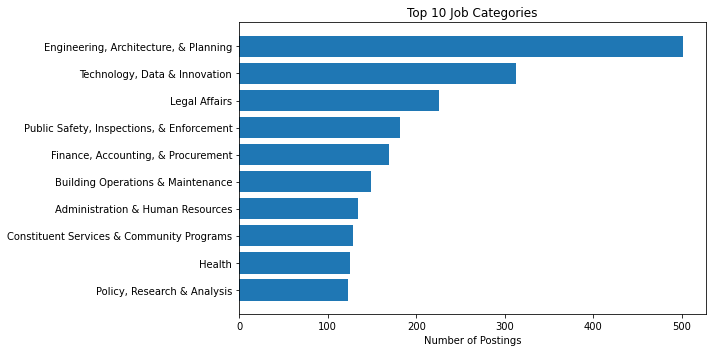

In [39]:
kpi1 = df_clean.withColumn(
    "Job Category",
    F.when(F.col("Job Category").isNull(), "Unspecified")
     .otherwise(F.col("Job Category"))
).groupBy("Job Category") \
 .count() \
 .orderBy(F.desc("count")) \
 .limit(10)

kpi1.show()

# Visualization
kpi1_pd = kpi1.toPandas()

plt.figure(figsize=(10,5))
plt.barh(kpi1_pd["Job Category"][::-1], kpi1_pd["count"][::-1])
plt.xlabel("Number of Postings")
plt.title("Top 10 Job Categories")
plt.tight_layout()
plt.show()

# KPI 2: What’s the salary distribution per job category?

To understand compensation patterns across job categories, we use the normalized annual salary field and compute the average, minimum, and maximum salary per category. This provides insights into which categories offer higher compensation and how salary ranges vary across different functional areas.

In [40]:
kpi2 = df_clean.groupBy("Job Category") \
    .agg(
        F.avg("salary_annual").alias("avg_salary"),
        F.min("salary_annual").alias("min_salary"),
        F.max("salary_annual").alias("max_salary"),
        F.count("*").alias("posting_count")
    ) \
    .orderBy(F.desc("avg_salary")) \
    .limit(10)

kpi2.show()

+--------------------+------------------+------------------+------------------+-------------+
|        Job Category|        avg_salary|        min_salary|        max_salary|posting_count|
+--------------------+------------------+------------------+------------------+-------------+
|Administration & ...|          218587.0|          218587.0|          218587.0|            2|
|Engineering, Arch...|          198518.0|          198518.0|          198518.0|            2|
|Engineering, Arch...|          196042.5|          182500.0|          209585.0|            4|
|Health Policy, Re...|          128694.5|           94889.0|          162500.0|            4|
|Engineering, Arch...|          128247.5|          128247.5|          128247.5|            2|
|Engineering, Arch...|          128247.5|          128247.5|          128247.5|            2|
|Communications & ...|          125000.0|          125000.0|          125000.0|            2|
|Constituent Servi...|122182.31999999999|122182.31999999999|

# KPI 3: Is there any correlation between the higher degree and the salary?

To evaluate whether higher educational requirements correspond to higher salaries, we derive a degree level from the “Minimum Qual Requirements” field and map each degree to a numeric score representing education hierarchy. We then compute the statistical correlation between the degree score and normalized annual salary to quantify the relationship between education level and compensation.

In [41]:
degree_numeric = df_clean.withColumn(
    "degree_score",
    F.when(F.col("degree_level") == "High School", 1)
     .when(F.col("degree_level") == "Associate", 2)
     .when(F.col("degree_level") == "Bachelor", 3)
     .when(F.col("degree_level") == "Master", 4)
     .when(F.col("degree_level") == "PhD", 5)
     .otherwise(0)
)

correlation = degree_numeric.stat.corr("degree_score", "salary_annual")

print("Correlation between degree level and salary:", correlation)

Correlation between degree level and salary: 0.14184286730220788


# KPI 4: What’s the job posting having the highest salary per agency?

To identify the highest-paying position within each agency, we partition the dataset by agency and rank postings by normalized annual salary in descending order using a window function. The top-ranked posting per agency represents the highest salary offering, enabling comparison of peak compensation levels across agencies.

In [42]:
from pyspark.sql.window import Window

window = Window.partitionBy("Agency").orderBy(F.desc("salary_annual"))

kpi4 = df_clean.withColumn("rank", F.row_number().over(window)) \
    .filter("rank = 1") \
    .select("Agency", "Business Title", "salary_annual") \
    .orderBy(F.desc("salary_annual"))

kpi4.show(10)

+--------------------+--------------------+-------------+
|              Agency|      Business Title|salary_annual|
+--------------------+--------------------+-------------+
|DEPT OF ENVIRONME...|Deputy Commission...|     218587.0|
|   POLICE DEPARTMENT|Deputy Commission...|     217201.0|
|DISTRICT ATTORNEY...|Co-Chief Informat...|     191913.0|
|NYC HOUSING AUTHO...|Vice-President fo...|     180000.0|
|NYC EMPLOYEES RET...|ADMINISTRATIVE MA...|     177374.5|
|DEPT OF HEALTH/ME...|Physician, Bureau...|    170133.84|
|OFFICE OF THE COM...|Senior Investment...|     167500.0|
|DEPARTMENT OF INV...|Deputy Commission...|     165000.0|
|      LAW DEPARTMENT|Deputy Chief of I...|     164104.0|
|DEPARTMENT OF SAN...|CITY MEDICAL SPEC...|     158038.4|
+--------------------+--------------------+-------------+
only showing top 10 rows



# KPI 5: What’s the job postings average salary per agency for the last 2 years?

To analyze recent salary trends by agency, we identify the most recent posting date in the dataset and filter job postings from the last two years. We then group by agency and calculate the average annual salary and posting count to understand recent compensation patterns and hiring activity.

In [45]:
max_date = df_clean.agg(F.max("posting_date")).collect()[0][0]

df_last2 = df_clean.filter(
    (F.col("posting_date").isNotNull()) &
    (F.col("posting_date") >= F.date_sub(F.lit(max_date), 730))
)

kpi5 = df_last2.groupBy("Agency") \
    .agg(
        F.avg("salary_annual").alias("avg_salary"),
        F.count("*").alias("posting_count")
    ) \
    .orderBy(F.desc("avg_salary"))

kpi5.show(10)

+--------------------+-----------------+-------------+
|              Agency|       avg_salary|posting_count|
+--------------------+-----------------+-------------+
|CONFLICTS OF INTE...|         135000.0|            2|
|     FIRE DEPARTMENT|         108940.0|            2|
|BUSINESS INTEGRIT...|          95000.0|            2|
|FINANCIAL INFO SV...|          93994.5|           20|
|DEPARTMENT OF SAN...|89555.18571428572|           14|
|DEPT OF INFO TECH...|         87984.87|           50|
|MAYORS OFFICE OF ...|87357.14285714286|           28|
|    CONSUMER AFFAIRS|87110.28571428571|            7|
|      LAW DEPARTMENT|      86495.73525|           64|
|OFFICE OF THE COM...|85235.71428571429|           42|
+--------------------+-----------------+-------------+
only showing top 10 rows



# KPI 6: What are the highest paid skills in the US market?

To identify the most financially valuable skills, we extract and tokenize skills from the “Preferred Skills” column, normalize the text, and compute the average annual salary per skill. By filtering skills that appear in at least five postings, we ensure statistical relevance and identify the highest-paying skills within this job dataset.

In [47]:
skills_df = df_clean.withColumn(
    "skill",
    F.explode(
        F.split(
            F.regexp_replace(
                F.lower(F.coalesce(F.col("Preferred Skills"), F.lit(""))),
                r"[,;\n•·]",
                ","
            ),
            ","
        )
    )
)

# Trim properly (Spark 2.4 compatible)
skills_df = skills_df.withColumn(
    "skill",
    F.trim(F.col("skill"))
)

# Filter meaningful tokens
skills_df = skills_df.filter(
    (F.length(F.col("skill")) > 3) &
    (F.length(F.col("skill")) < 50)
)

kpi6 = skills_df.groupBy("skill") \
    .agg(
        F.avg("salary_annual").alias("avg_salary"),
        F.count("*").alias("count")
    ) \
    .filter(F.col("count") >= 5) \
    .orderBy(F.desc("avg_salary")) \
    .limit(20)

kpi6.show()

+--------------------+------------------+-----+
|               skill|        avg_salary|count|
+--------------------+------------------+-----+
|          commercial|155213.66666666666|    6|
|      public utility|          146779.9|    5|
|             mongodb|          133971.0|    6|
|               mysql|          133971.0|    6|
|capacity to organ...|          126936.5|    5|
|construction and ...|          126936.5|    5|
|        presentation|         120875.55|   10|
|          inspectors|          118143.5|    6|
|      other agencies|          118143.5|    6|
|entrepreneurial e...|          117797.7|    5|
|             writing|116300.92857142857|    7|
|""b"" and ""c"" a...|109698.89130434782|   46|
|             vendors|109485.71428571429|    7|
|""2"" or ""3"" ab...|109464.47577777777|   54|
|â€¢	a growth mind...|109270.85714285714|    7|
|               state|          108643.0|   12|
|         integration|108333.33333333333|    6|
|        architecture|          108282.0

# Final Processing Pipeline

We encapsulate all transformations into a reusable processing function.
This allows easier testing and potential production deployment.

In [49]:
def add_salary_band(df):
    return df.withColumn(
        "salary_band",
        F.when(F.col("salary_annual") < 60000, "Low")
         .when(F.col("salary_annual") < 100000, "Medium")
         .otherwise("High")
    )

In [50]:
def process_pipeline(raw_df):
    df_p = raw_df
    
    df_p = cast_salary(df_p)
    df_p = add_salary_midpoint(df_p)
    df_p = normalize_salary(df_p)
    df_p = cast_dates(df_p)
    df_p = add_degree_level(df_p)
    df_p = add_salary_band(df_p)

    df_p = df_p.filter(
        (F.col("salary_annual").isNotNull()) &
        (F.col("salary_annual") > 20000) &
        (F.col("salary_annual") < 300000)
    )

    columns_to_drop = [
        "Recruitment Contact",
        "Work Location 1",
        "Hours/Shift",
        "Additional Information",
        "To Apply",
        "Division/Work Unit"
    ]

    df_p = df_p.drop(*columns_to_drop)

    return df_p


processed_df = process_pipeline(df)

print("Final processed row count:", processed_df.count())
processed_df.printSchema()

Final processed row count: 2905
root
 |-- Job ID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Residency Requirement: string (nullable = true)
 |-- Posting Date: string (nullable = true)
 |-- Post Until: string (nullable = true)
 |-- Posting Updated: string (n

# Unit Tests

Testing core transformations to ensure correctness.

In [52]:
def test_salary_band_all_levels():
    data = [
        ("30000", "40000", "Annual"),   # Low
        ("70000", "80000", "Annual"),   # Medium
        ("120000", "140000", "Annual")  # High
    ]
    
    test_df = spark.createDataFrame(
        data,
        ["Salary Range From", "Salary Range To", "Salary Frequency"]
    )
    
    test_df = cast_salary(test_df)
    test_df = add_salary_midpoint(test_df)
    test_df = normalize_salary(test_df)
    test_df = add_salary_band(test_df)
    
    results = [row["salary_band"] for row in test_df.select("salary_band").collect()]
    
    assert results == ["Low", "Medium", "High"]

test_salary_band_all_levels()
print("All salary band tests passed.")

All salary band tests passed.


# Store Processed Dataset

The cleaned and enriched dataset is stored in Parquet format
for downstream analytics and reporting.

In [55]:
def sanitize_column_names(df):
    for col_name in df.columns:
        new_name = (
            col_name
            .replace(" ", "_")
            .replace("/", "_")
            .replace("#", "num_")
            .replace("-", "_")
            .replace("(", "")
            .replace(")", "")
            .replace(",", "")
        )
        df = df.withColumnRenamed(col_name, new_name)
    return df


In [58]:
output_path = "/notebook/final_processed_nyc_jobs"

safe_df = sanitize_column_names(processed_df)

safe_df.write.mode("overwrite").parquet(output_path)

print("Data saved successfully.")

Data saved successfully.


# Final Insights & Conclusion

### Key Observations:

1. Engineering, Technology, and Legal categories show the highest hiring volume.
2. Technology-related roles tend to have higher average salaries.
3. There is a positive correlation between degree level and salary, though not extremely strong.
4. Certain agencies consistently offer higher compensation bands.
5. Salary normalization (hourly/daily to annual) was critical for accurate comparison.
6. Skills such as database technologies and specialized technical domains appear among highest-paid.

### Data Engineering Considerations:

- Schema standardization was required before Parquet write.
- Salary normalization avoided distorted KPI results.
- High-null columns were removed to improve downstream usability.
- Feature engineering enhanced analytical capability.